In [ ]:
pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu118

  You can safely remove it manually.

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu118
   ---------------------------------------- 0.0/2.7 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 GB 3.0 MB/s eta 0:14:55
   ---------------------------------------- 0.0/2.7 GB 4.3 MB/s eta 0:10:28
   ---------------------------------------- 0.0/2.7 GB 5.2 MB/s eta 0:08:48
   ---------------------------------------- 0.0/2.7 GB 5.6 MB/s eta 0:08:08
   ---------------------------------------- 0.0/2.7 GB 6.4 MB/s eta 0:07:09
   ---------------------------------------- 0.0/2.7 GB 7.1 MB/s eta 0:06:22
   ---------------------------------------- 0.0/2.7 GB 7.6 MB/s eta 0:05:59
   ---------------------------------------- 0.0/2.7 GB 7.9 MB/s eta 0:05:44
   ---------------------------------------- 0.0/2.7 GB 8.2 MB/s eta 0:05:32
   ---------------------------------------- 0.0/2.

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

### DATASET

In [3]:
# Load the Excel file
file_path = 'pil_test.xlsx'  # Update the path if the file is located elsewhere
df = pd.read_excel(file_path)

# Check the first few rows of the data to ensure it's loaded correctly
print(df.head())

   Unnamed: 0  Zaman  Maxell     GP  Fujitsu  Duracell
0         NaN    0.0   3.307  3.301    3.287     3.238
1         NaN    0.0   3.307  3.301    3.287     3.238
2         NaN    1.0   3.307  3.301    3.287     3.240
3         NaN    3.0   3.112  3.035    3.091     3.071
4         NaN    5.0   3.066  3.015    3.051     3.039


### PREPROCESSING

fill null values

In [4]:
print(df.isna().sum())

Unnamed: 0    6370
Zaman          315
Maxell         317
GP             315
Fujitsu          0
Duracell       372
dtype: int64


In [5]:
print(f"Number of rows remaining: {df.shape[0]}")

Number of rows remaining: 6370


In [6]:
df = df.drop(columns=['Unnamed: 0'])


print(df.isna().sum())

Zaman       315
Maxell      317
GP          315
Fujitsu       0
Duracell    372
dtype: int64


In [7]:
print(f"Number of rows remaining: {df.shape}")
print(df)


Number of rows remaining: (6370, 5)
      Zaman  Maxell     GP  Fujitsu  Duracell
0       0.0   3.307  3.301    3.287     3.238
1       0.0   3.307  3.301    3.287     3.238
2       1.0   3.307  3.301    3.287     3.240
3       3.0   3.112  3.035    3.091     3.071
4       5.0   3.066  3.015    3.051     3.039
...     ...     ...    ...      ...       ...
6365    NaN     NaN    NaN    1.804       NaN
6366    NaN     NaN    NaN    1.802       NaN
6367    NaN     NaN    NaN    1.803       NaN
6368    NaN     NaN    NaN    1.802       NaN
6369    NaN     NaN    NaN    1.800       NaN

[6370 rows x 5 columns]


In [8]:


# Make a copy of the dataframe
df_interp = df.copy()

# Check if there are any NaN values in 'Zaman'
if df_interp['Zaman'].isna().any():
    # Get the last non-null value in 'Zaman'
    last_valid_value = df_interp['Zaman'].ffill().iloc[-1]
    
    # Identify NaN rows in 'Zaman' column
    nan_mask = df_interp['Zaman'].isna()
    nan_indices = df_interp.index[nan_mask]
    num_nans = len(nan_indices)
    
    # Generate the sequence starting from last_valid_value + 2 with step 2
    fill_values = np.arange(last_valid_value + 2, 
                          last_valid_value + 2 + 2*num_nans, 
                          2)
    
    # Fill the NaN values
    df_interp.loc[nan_indices, 'Zaman'] = fill_values
    
    print("\nCustom Increment for Zaman:")
    print(df_interp)
else:
    print("No NaN values found in 'Zaman' column")


Custom Increment for Zaman:
        Zaman  Maxell     GP  Fujitsu  Duracell
0         0.0   3.307  3.301    3.287     3.238
1         0.0   3.307  3.301    3.287     3.238
2         1.0   3.307  3.301    3.287     3.240
3         3.0   3.112  3.035    3.091     3.071
4         5.0   3.066  3.015    3.051     3.039
...       ...     ...    ...      ...       ...
6365  12752.0     NaN    NaN    1.804       NaN
6366  12754.0     NaN    NaN    1.802       NaN
6367  12756.0     NaN    NaN    1.803       NaN
6368  12758.0     NaN    NaN    1.802       NaN
6369  12760.0     NaN    NaN    1.800       NaN

[6370 rows x 5 columns]


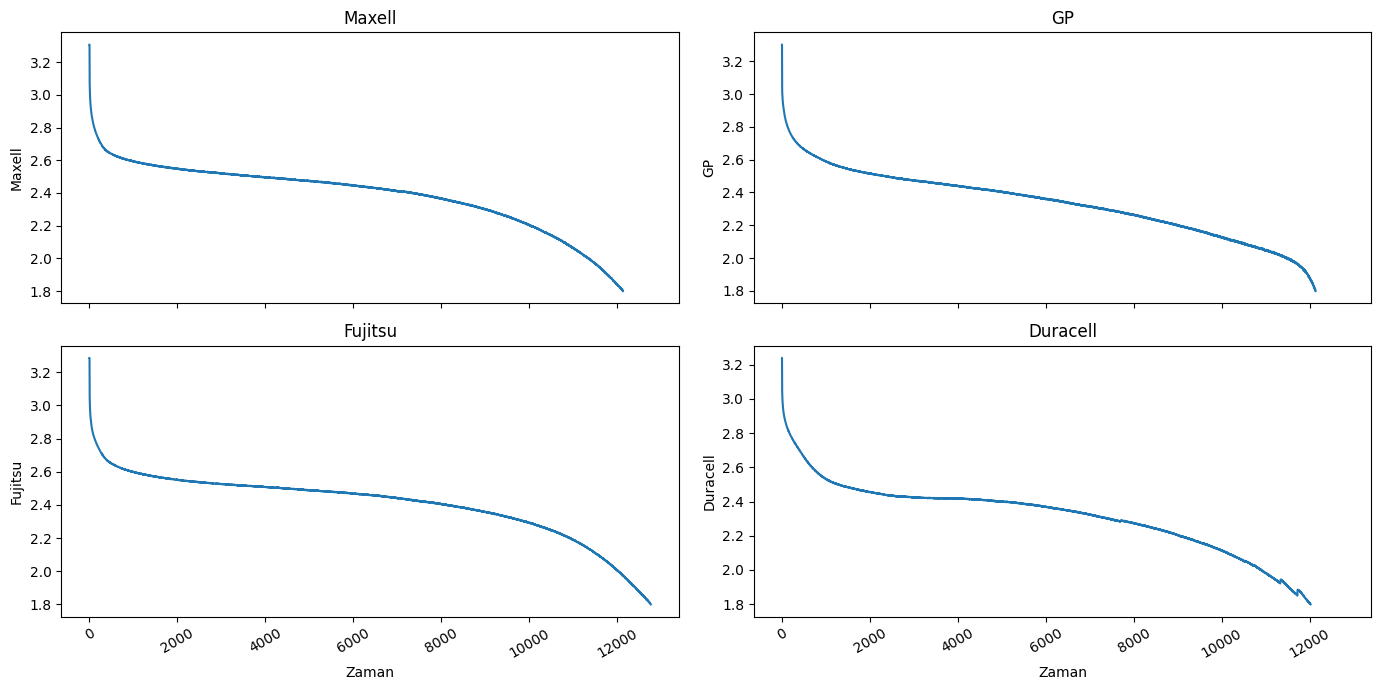

In [9]:

def data_plot(df):
    # Make a copy
    df_plot = df.copy()

    # Set 'zaman' as the x-axis
    x = df_plot['Zaman']
    df_plot = df_plot.drop(columns=['Zaman'])  # Only battery columns now

    ncols = 2
    nrows = (df_plot.shape[1] + ncols - 1) // ncols  # Better way to calculate rows

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 7), sharex=True)

    axes = axes.flatten()  # Flatten in case of (2,2) axes array

    for i, col in enumerate(df_plot.columns):
        sns.lineplot(x=x, y=df_plot[col], ax=axes[i])
        axes[i].set_title(col)
        axes[i].tick_params(axis="x", rotation=30)

    # Hide empty plots if any
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    fig.tight_layout()
    plt.show()

# Call the function
data_plot(df_interp)

In [10]:
voltage_data = df[['Maxell', 'GP', 'Fujitsu', 'Duracell']].values

In [11]:
voltage_combined = np.concatenate([
    df['Maxell'].dropna().values,
    df['GP'].dropna().values,
    df['Fujitsu'].dropna().values,
    df['Duracell'].dropna().values
])

In [12]:
print("Number of NaN values:", np.isnan(voltage_combined).sum())

Number of NaN values: 0


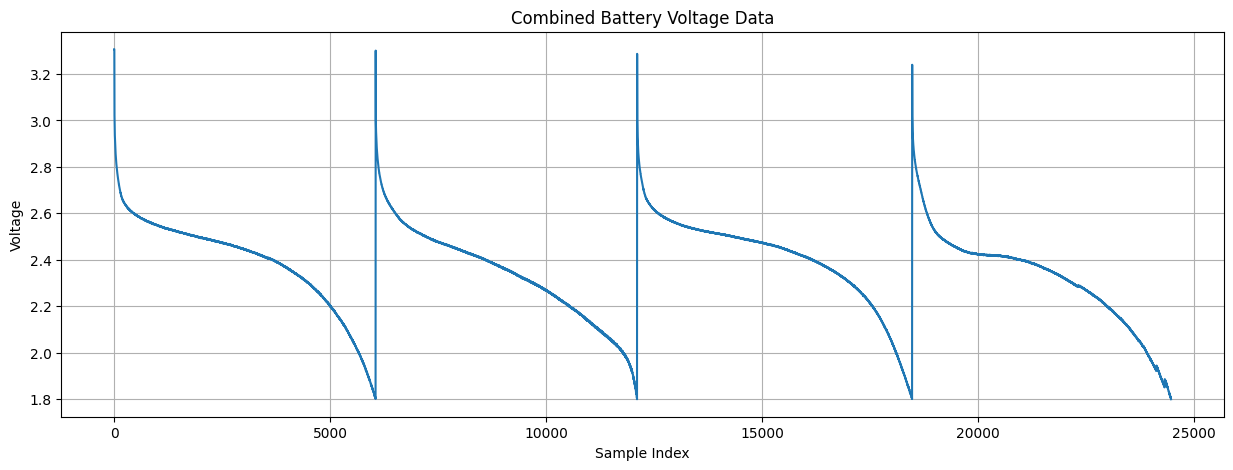

In [13]:

plt.figure(figsize=(15,5))
plt.plot(voltage_combined)
plt.title('Combined Battery Voltage Data')
plt.xlabel('Sample Index')
plt.ylabel('Voltage')
plt.grid(True)
plt.show()


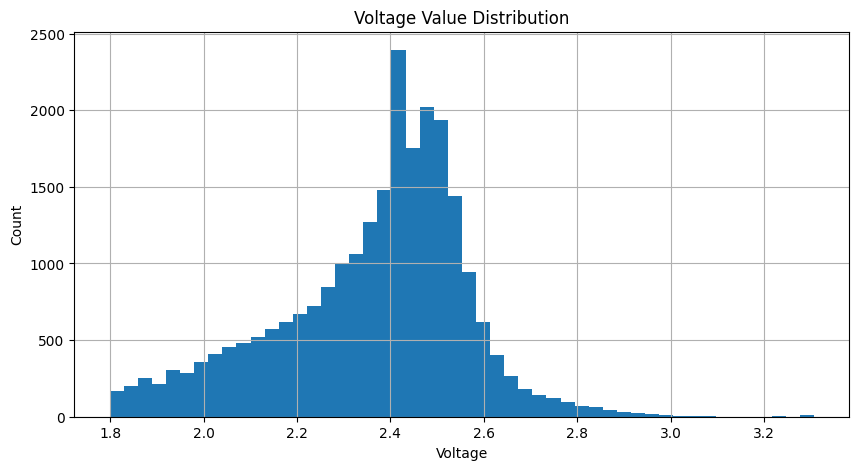

In [14]:
plt.figure(figsize=(10,5))
plt.hist(voltage_combined, bins=50)
plt.title('Voltage Value Distribution')
plt.xlabel('Voltage')
plt.ylabel('Count')
plt.grid(True)
plt.show()


In [15]:

# import math
# # Train test split
# training_data_len = math.ceil(len(voltage_combined) * .8)
# print(training_data_len)
# # Splitting the dataset
# train_data = voltage_combined[:training_data_len]
# test_data = voltage_combined[training_data_len:]


# print("Before val split:", train_data.shape, test_data.shape)

# # 2. Now split the train_data_full into train/validation
# val_split = 0.2  # 20% of the training data will be for validation
# val_data_len = math.ceil(len(train_data) * val_split)

# val_data = train_data[-val_data_len:]   # Take the last 20% for validation
# train_data = train_data[:-val_data_len] # Take the first 80% for training

# print("Train:", train_data.shape)
# print("Validation:", val_data.shape)
# print("Test:", test_data.shape)


train_size = int(0.7 * len(voltage_combined))
val_size = int(0.15 * len(voltage_combined))
train_data, val_data, test_data = voltage_combined[:train_size], voltage_combined[train_size:train_size+val_size], voltage_combined[train_size+val_size:]

In [16]:
train_data = train_data.reshape(-1, 1)
val_data = val_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Step 1: Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))


# Fit the scaler on the training data only
scaler.fit(train_data)  # This learns the scaling parameters from the training data

# Step 2: Transform the training, validation, and test data
scaled_train = scaler.transform(train_data).flatten()   # Transform the training data
scaled_val = scaler.transform(val_data).flatten()     # Transform the validation data
scaled_test = scaler.transform(test_data).flatten()    # Transform the test data

# Print the first few scaled values
print(scaled_train[:5])
print(scaled_val[:5])
print(scaled_test[:5])


[1.         1.         1.         0.87068966 0.84018568]
[0.32360743 0.32228117 0.32228117 0.32228117 0.32360743]
[0.40384615 0.40318302 0.40384615 0.40450928 0.40384615]


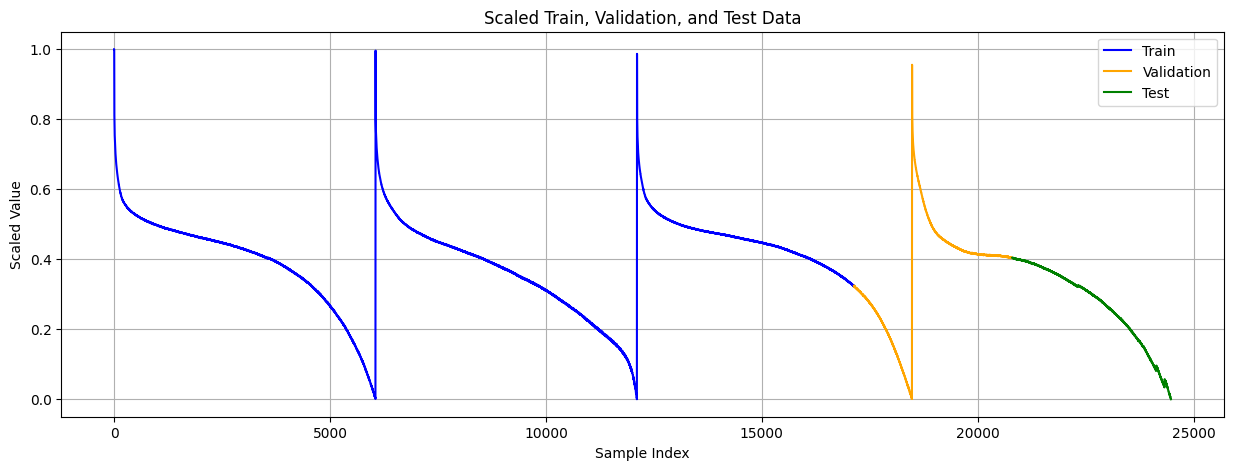

In [17]:
# Create a figure
plt.figure(figsize=(15, 5))

# Plot training data
plt.plot(scaled_train, label='Train', color='blue')

# Plot validation data
plt.plot(range(len(scaled_train), len(scaled_train) + len(scaled_val)), scaled_val, label='Validation', color='orange')

# Plot test data
plt.plot(range(len(scaled_train) + len(scaled_val), len(scaled_train) + len(scaled_val) + len(scaled_test)), scaled_test, label='Test', color='green')

# Decorations
plt.title('Scaled Train, Validation, and Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Create sequences and labels for training data
sequence_length = 67  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])  # Predicting the value right after the sequence
X_train, y_train = np.array(X_train), np.array(y_train)

# Create sequences and labels for testing data
sequence_length = 67  # Number of time steps to look back
X_val, y_val = [], []
for i in range(len(scaled_val) - sequence_length):
    X_val.append(scaled_val[i:i + sequence_length])
    y_val.append(scaled_val[i + sequence_length])  # Predicting the value right after the sequence
X_val, y_test = np.array(X_val), np.array(y_val)

# Create sequences and labels for testing data
sequence_length = 67  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])  # Predicting the value right after the sequence
X_test, y_test = np.array(X_test), np.array(y_test)



In [19]:

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# Convert data to PyTorch tensors
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
print(X_val.shape, y_val.shape)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([17066, 67]) torch.Size([17066])
torch.Size([3604, 67]) torch.Size([3604])
torch.Size([3605, 67]) torch.Size([3605])


In [80]:
# import datetime


# time_data_as_timestamp = [str(datetime.timedelta(seconds=int(time))) for time in x_train_split]
# print(time_data_as_timestamp) 

In [20]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader for batching
batch_size = 32  # You can change the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the shapes of the first batch
for batch_x, batch_y in train_loader:
    print(f"Batch x shape: {batch_x.shape}")  # Should be [batch_size, 67, 1]
    print(f"Batch y shape: {batch_y.shape}")  # Should be [batch_size, 1]
    break  # Only print the first batch for inspection

Batch x shape: torch.Size([32, 67])
Batch y shape: torch.Size([32])


### LSTM MODEL

In [21]:
PATH = 'LSTM_model.pth'  # Path to the saved weights
model = torch.load(PATH, map_location=torch.device('cpu'), weights_only=False)

# Set the model to evaluation mode
model.eval()


SOHMode(
  (pre_net): Linear(in_features=67, out_features=512, bias=True)
  (backbone): LSTM(
    (net): LSTM(4, 128, num_layers=2, batch_first=True)
    (predictor): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (mse): MSELoss()
)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the device

SOHMode(
  (pre_net): Linear(in_features=67, out_features=512, bias=True)
  (backbone): LSTM(
    (net): LSTM(4, 128, num_layers=2, batch_first=True)
    (predictor): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (mse): MSELoss()
)

In [107]:
# for param in model.parameters():
#     param.requires_grad = False

In [23]:

print(torch.cuda.is_available())

True


In [24]:
def calculate_metrics_sklearn(y_true, y_pred):
    """Calculate R², MAE, MSE, and MAPE using sklearn metrics."""
    # R²
    r2 = r2_score(y_true, y_pred)

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)

    # MSE (Mean Squared Error)
    mse = mean_squared_error(y_true, y_pred)

    # MAPE (Mean Absolute Percentage Error)
    # mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # Multiply by 100 to get percentage

    return r2, mae, mse

def Train(model, train_loader, valid_loader, test_loader, args, save_folder=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)  # Ensure the model is on the correct device

    # Initialize optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)

    # Define loss function
    mse_loss = torch.nn.MSELoss()

    min_loss = 10
    stop = 0
    train_losses = []
    valid_losses = []
    best_state = None

    # Store metrics for train, validation, and test
    train_r2_values = []
    valid_r2_values = []

    for e in range(1, args.n_epoch + 1):
        # --------- Train one epoch manually ---------
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_labels = []
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            label = label.unsqueeze(1)
            pred = model(data)
            loss = mse_loss(pred, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            all_train_preds.append(pred.cpu().detach().numpy())
            all_train_labels.append(label.cpu().detach().numpy())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Calculate metrics for training
        all_train_preds = np.concatenate(all_train_preds, axis=0)
        all_train_labels = np.concatenate(all_train_labels, axis=0)
        train_r2, train_mae,train_mse = calculate_metrics_sklearn(all_train_labels, all_train_preds)
        train_r2_values.append(train_r2)

        scheduler.step()

        # --------- Validation manually ---------
        model.eval()
        valid_loss = 0
        all_valid_preds = []
        all_valid_labels = []
        with torch.no_grad():
            for data, label in valid_loader:
                data, label = data.to(device), label.to(device)
                label = label.unsqueeze(1)
                pred = model(data)
                loss = mse_loss(pred, label)
                valid_loss += loss.item()

                all_valid_preds.append(pred.cpu().detach().numpy())
                all_valid_labels.append(label.cpu().detach().numpy())

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)

        # Calculate metrics for validation
        all_valid_preds = np.concatenate(all_valid_preds, axis=0)
        all_valid_labels = np.concatenate(all_valid_labels, axis=0)
        valid_r2, valid_mae, valid_mse = calculate_metrics_sklearn(all_valid_labels, all_valid_preds)
        valid_r2_values.append(valid_r2)

        lr = optimizer.state_dict()['param_groups'][0]['lr']
        
        # Print each epoch's training and validation results
        print(f"Epoch [{e}/{args.n_epoch}] - Train Loss: {train_loss:.5f} | Train R²: {train_r2:.5f} | Train MAE: {train_mae:.5f} | Train MSE: {train_mse:.5f}")
        print(f"             - Valid Loss: {valid_loss:.5f} | Valid R²: {valid_r2:.5f} | Valid MAE: {valid_mae:.5f} | Valid MSE: {valid_mse:.5f}")
    
        
        if e % 10 == 0:
            print()  # Newline every 10 epochs for clarity

        # --------- Save best model ---------
        if valid_loss < min_loss:
            best_state = model.state_dict()
            min_loss = valid_loss
            stop = 0
        else: stop += 1
        # --------- Early stopping ---------
        if stop >= args.early_stop:
            print("\nEarly stopping triggered.")
            break

    # --------- After all epochs, evaluate on test set ---------
    test_loss = 0
    all_test_preds = []
    all_test_labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            label = label.unsqueeze(1)
            pred = model(data)
            loss = mse_loss(pred, label)
            test_loss += loss.item()

            all_test_preds.append(pred.cpu().detach().numpy())
            all_test_labels.append(label.cpu().detach().numpy())

    test_loss /= len(test_loader)

    # Flatten the predictions and labels for metric calculations
    all_test_preds = np.concatenate(all_test_preds, axis=0)
    all_test_labels = np.concatenate(all_test_labels, axis=0)
    
    # Calculate metrics for test set
    test_r2, test_mae, test_mse = calculate_metrics_sklearn(all_test_labels, all_test_preds)

    # Print test results at the end of training
    print(f"Final Test Loss: {test_loss:.5f}, Test R²: {test_r2:.5f}, Test MAE: {test_mae:.5f}, Test MSE: {test_mse:.5f}")

    # --------- Save model ---------
    # if save_folder is not None and best_state is not None:
    #     torch.save(best_state, save_folder + '/best_model.pth')

    return train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2


In [25]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2 = Train(model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.01597 | Train R²: -0.04787 | Train MAE: 0.06680 | Train MSE: 0.01599
             - Valid Loss: 0.02256 | Valid R²: 0.04209 | Valid MAE: 0.12224 | Valid MSE: 0.02263
Epoch [2/100] - Train Loss: 0.01203 | Train R²: 0.21075 | Train MAE: 0.06338 | Train MSE: 0.01204
             - Valid Loss: 0.01893 | Valid R²: 0.19636 | Valid MAE: 0.11054 | Valid MSE: 0.01899
Epoch [3/100] - Train Loss: 0.00791 | Train R²: 0.48120 | Train MAE: 0.04755 | Train MSE: 0.00792
             - Valid Loss: 0.00942 | Valid R²: 0.60012 | Valid MAE: 0.07378 | Valid MSE: 0.00945
Epoch [4/100] - Train Loss: 0.00315 | Train R²: 0.79319 | Train MAE: 0.02233 | Train MSE: 0.00316
             - Valid Loss: 0.00549 | Valid R²: 0.76684 | Valid MAE: 0.04690 | Valid MSE: 0.00551
Epoch [5/100] - Train Loss: 0.00207 | Train R²: 0.86399 | Train MAE: 0.01510 | Train MSE: 0.00208
             - Valid Loss: 0.00476 | Valid R²: 0.79785 | Valid MAE: 0.04252 | Valid MSE: 0.00478
Epoch [6/100] - Train Lo

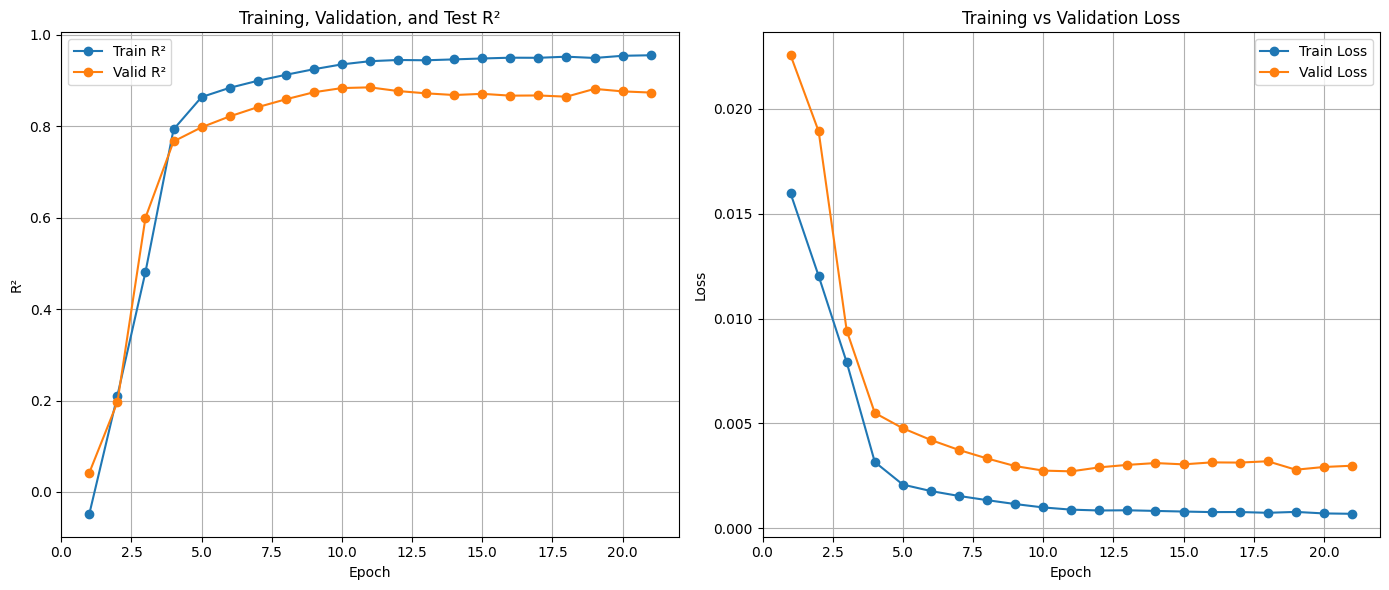

In [29]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [39]:

PATH = 'LSTM_model.pth'  # Path to the saved weights
model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)

# Set the model to evaluation mode
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the device

SOHMode(
  (pre_net): Linear(in_features=67, out_features=512, bias=True)
  (backbone): LSTM(
    (net): LSTM(4, 128, num_layers=2, batch_first=True)
    (predictor): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (mse): MSELoss()
)

In [40]:
for name, param in model.named_parameters():
    if 'predictor' not in name:  # This checks if the parameter is not in the 'predictor' layer
        param.requires_grad = False
    else:
        param.requires_grad = True  # Allow the last layer to be trainable

In [41]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2 = Train(model, train_loader, val_loader, test_loader, args)

Epoch [1/100] - Train Loss: 0.02082 | Train R²: -0.36599 | Train MAE: 0.09800 | Train MSE: 0.02084
             - Valid Loss: 0.02376 | Valid R²: -0.00898 | Valid MAE: 0.12080 | Valid MSE: 0.02384
Epoch [2/100] - Train Loss: 0.01331 | Train R²: 0.12701 | Train MAE: 0.07029 | Train MSE: 0.01332
             - Valid Loss: 0.02371 | Valid R²: -0.00679 | Valid MAE: 0.12161 | Valid MSE: 0.02379
Epoch [3/100] - Train Loss: 0.01321 | Train R²: 0.13299 | Train MAE: 0.07061 | Train MSE: 0.01323
             - Valid Loss: 0.02374 | Valid R²: -0.00795 | Valid MAE: 0.12116 | Valid MSE: 0.02381
Epoch [4/100] - Train Loss: 0.01339 | Train R²: 0.12135 | Train MAE: 0.07230 | Train MSE: 0.01341
             - Valid Loss: 0.02380 | Valid R²: -0.01045 | Valid MAE: 0.12038 | Valid MSE: 0.02387
Epoch [5/100] - Train Loss: 0.01366 | Train R²: 0.10408 | Train MAE: 0.07466 | Train MSE: 0.01367
             - Valid Loss: 0.02390 | Valid R²: -0.01479 | Valid MAE: 0.11933 | Valid MSE: 0.02398
Epoch [6/100] - Tra

ValueError: too many values to unpack (expected 6)

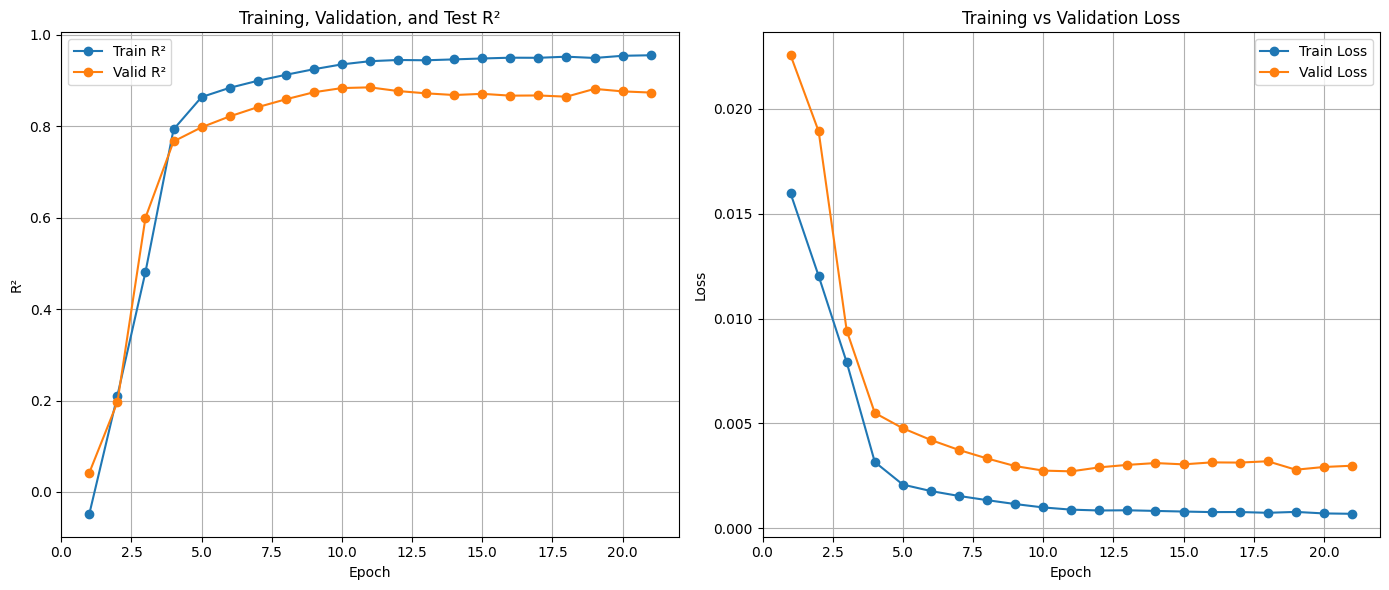

In [42]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


lstm not working good with freezing because:

### GRU MODEL

In [ ]:

PATH = 'GRU_model.pth'  # Path to the saved weights
model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)

# Set the model to evaluation mode
model.eval()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the device

In [ ]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2 = Train(model, train_loader, val_loader, test_loader, args, save_folder="my_models")

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### CNN MODEL

In [ ]:

PATH = 'CNN_model.pth'  # Path to the saved weights
model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)

# Set the model to evaluation mode
model.eval()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the device

In [ ]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(model, train_loader, val_loader, test_loader, args, save_folder="my_models")

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### MLP MODEL

In [ ]:

PATH = 'MLP_model.pth'  # Path to the saved weights
model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)

# Set the model to evaluation mode
model.eval()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the device

In [ ]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(model, train_loader, val_loader, test_loader, args, save_folder="my_models")

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### ATTENTION MODEL

In [ ]:

PATH = 'Attention_model.pth'  # Path to the saved weights
model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)

# Set the model to evaluation mode
model.eval()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the device

In [ ]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2 ,all_test_labels, all_test_preds= Train(model, train_loader, val_loader, test_loader, args, save_folder="my_models")